In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import training
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?

Normalisation:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again

In [2]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=100)

21.06.2022 15:42:43 Creating Training Directory at 2022-06-21_15-42_MinCut_CG_Classifier/
21.06.2022 15:42:43 Using CUDNN Benchmark
21.06.2022 15:42:44 Loading Datasets
21.06.2022 15:42:44 Start Training


Epoch 0: Training loss 17.5543; Validation loss 22.0864, MAE: 22.2720; lr: 0.00000
	Add. Loss: Training 0.2548, Validation 0.2532
Epoch 5: Training loss 17.5495; Validation loss 22.0446, MAE: 22.2406; lr: 0.00010
	Add. Loss: Training 0.2498, Validation 0.2466
Epoch 10: Training loss 17.3548; Validation loss 21.8538, MAE: 22.0762; lr: 0.00020
	Add. Loss: Training 0.2382, Validation 0.2368
Epoch 15: Training loss 16.7963; Validation loss 21.3399, MAE: 21.5913; lr: 0.00030
	Add. Loss: Training 0.2320, Validation 0.2331
Epoch 20: Training loss 14.8577; Validation loss 19.7274, MAE: 19.9950; lr: 0.00040
	Add. Loss: Training 0.2294, Validation 0.2310
Epoch 25: Training loss 8.3087; Validation loss 15.2638, MAE: 15.5305; lr: 0.00050
	Add. Loss: Training 0.2286, Validation 0.2315
Epoch 30: Training loss 3.2312; Validation loss 14.0447, MAE: 14.3080; lr: 0.00060
	Add. Loss: Training 0.2281, Validation 0.2300
Epoch 35: Training loss 2.8297; Validation loss 14.5537, MAE: 14.8182; lr: 0.00070
	Add

KeyboardInterrupt: 

In [3]:
#get training run data

run_dir = "run_data/2022-06-21_15-42_MinCut_CG_Classifier"
burn_in = 150

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.2369 in epoch 2990
Minimum Validation Loss (after 150 epochs) 12.5887 in epoch 2455
Minimum MAE (after 150 epochs) 12.8505 in epoch 2455


Validation Loss at 2455 is 12.5887
5 before select
13.3720, 13.2243, 13.1198, 13.0989, 12.9079
5 after select
12.7715, 12.9736, 13.1408, 13.1616, 12.9507
MAE at 2455 is 12.8505


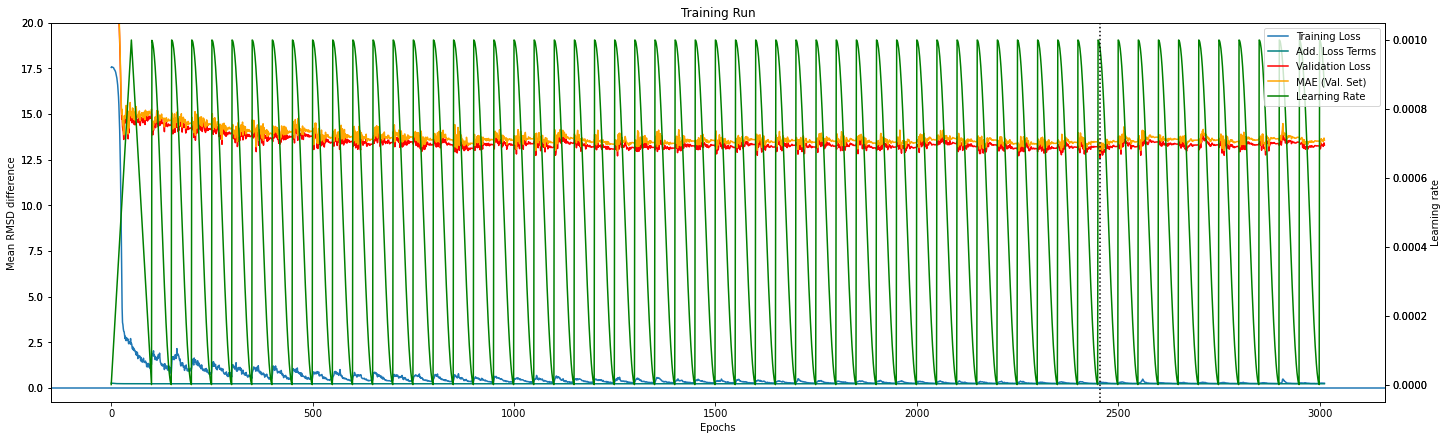

In [4]:
#plot the training run
select = 2455

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ybound(lower=(min(epoch_losses)-1), upper=20)#max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0)

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 2455
Test Set
Minimum Loss: Label = 25.9380, Prediction = 25.9011, Loss = 0.0007
Maximum Loss: Label = 0.0000, Prediction = 27.6593, Loss = 27.1593
Mean Test loss: 	 11.5351
Std. Dev. of Test loss:  8.8021
Min loss: 		 0.0007
First Quantile: 	 3.1504
Median: 		 10.2406
Third Quantile: 	 20.3270
Max Loss: 		 27.1593
LinregressResult(slope=-0.008486720383962828, intercept=17.01815697137131, rvalue=-0.0022870099477779746, pvalue=0.9697743043956655, stderr=0.22377128569975244, intercept_stderr=5.425321944711698)


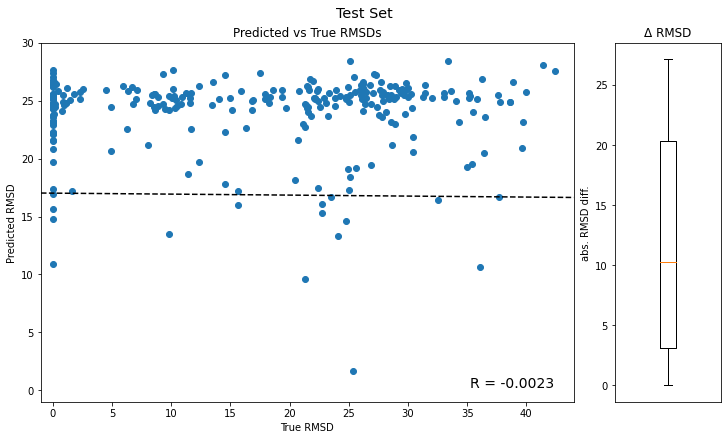

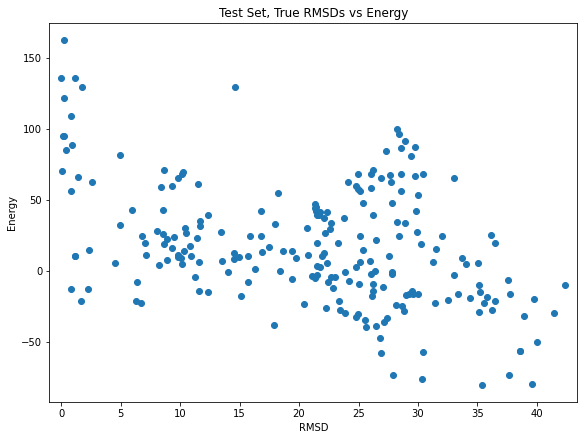

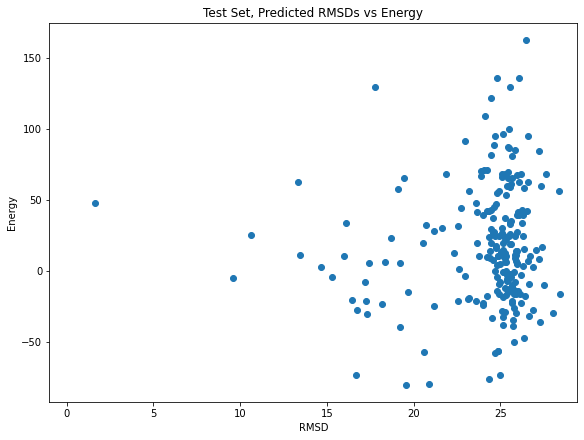

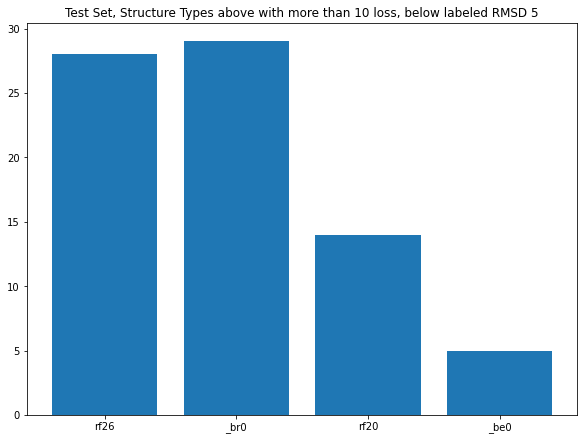

Prediction below 0: Label 26.2490, Pred -23.4581
Prediction below 0: Label 19.5830, Pred -2.2954
5S and tRNA Test Set
Minimum Loss: Label = 24.3650, Prediction = 24.3397, Loss = 0.0003
Maximum Loss: Label = 26.2490, Prediction = -23.4581, Loss = 49.2071
Mean Test loss: 	 9.6230
Std. Dev. of Test loss:  8.0154
Min loss: 		 0.0003
First Quantile: 	 3.3339
Median: 		 7.2929
Third Quantile: 	 13.4577
Max Loss: 		 49.2071
LinregressResult(slope=-0.1279092693297247, intercept=18.933994756631833, rvalue=-0.0641485397029891, pvalue=0.03478963799369398, stderr=0.060521123917899, intercept_stderr=1.4635514710211446)


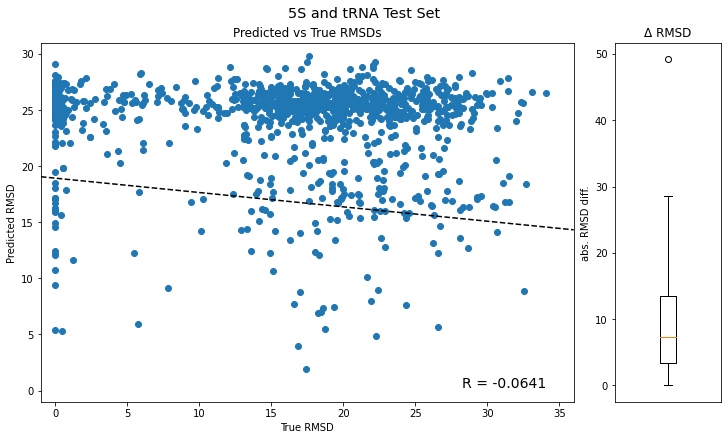

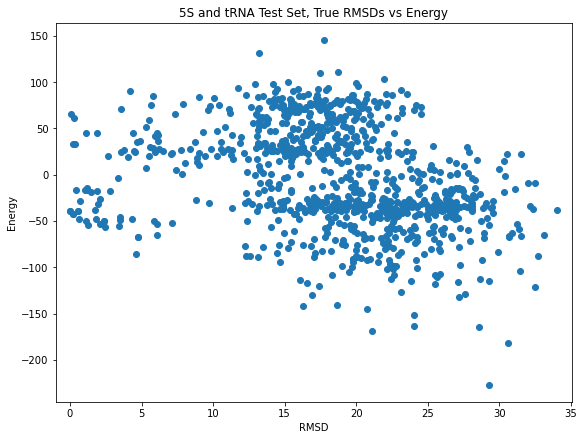

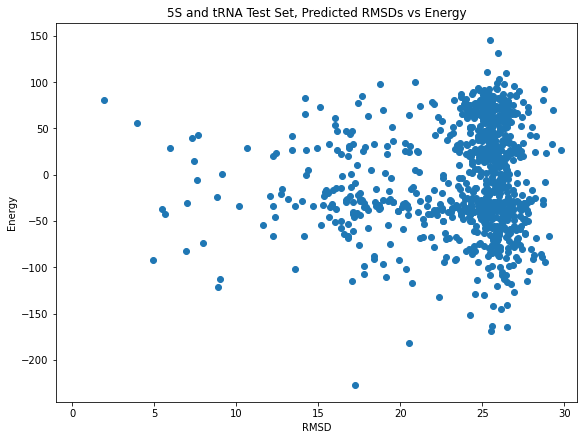

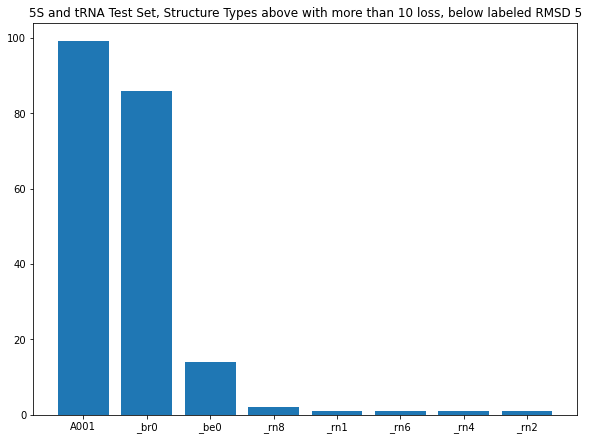

Training Set
Minimum Loss: Label = 25.8220, Prediction = 25.8433, Loss = 0.0002
Maximum Loss: Label = 0.1620, Prediction = 28.2894, Loss = 27.6274
Mean Test loss: 	 9.4207
Std. Dev. of Test loss:  6.9900
Min loss: 		 0.0002
First Quantile: 	 3.6801
Median: 		 7.9340
Third Quantile: 	 14.0109
Max Loss: 		 27.6274
LinregressResult(slope=-0.38653725131268485, intercept=27.154077308078605, rvalue=-0.1623677526898627, pvalue=6.837446029059763e-06, stderr=0.08532090281327881, intercept_stderr=2.0694987120963213)


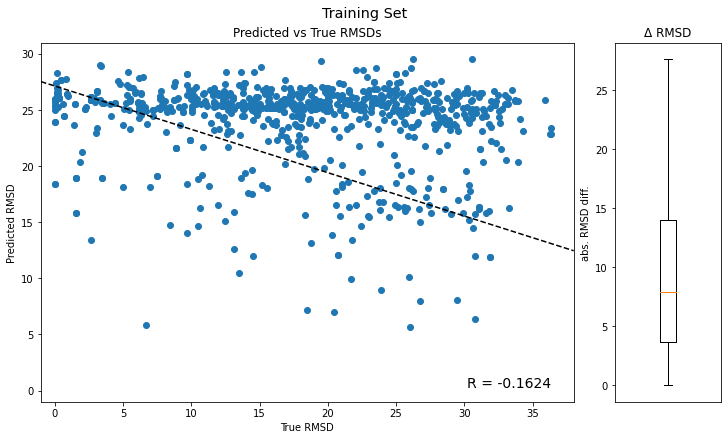

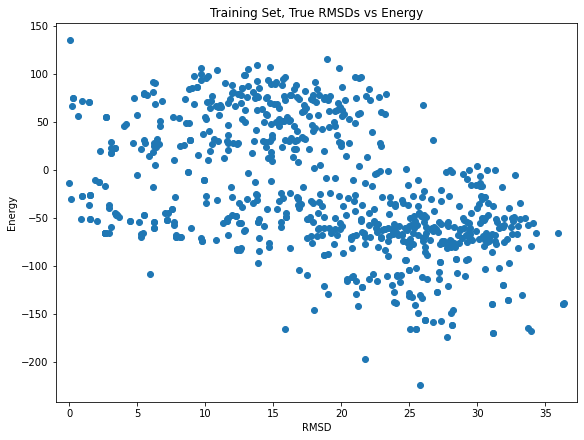

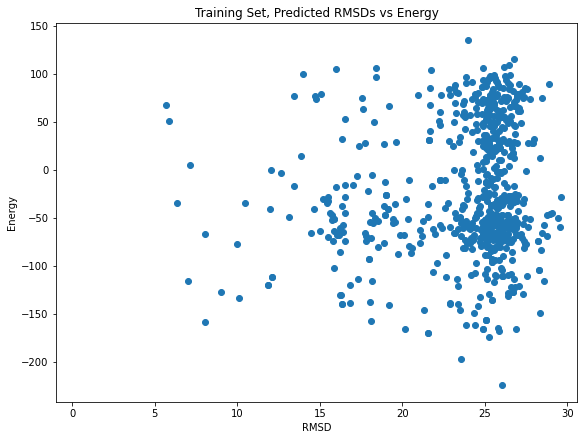

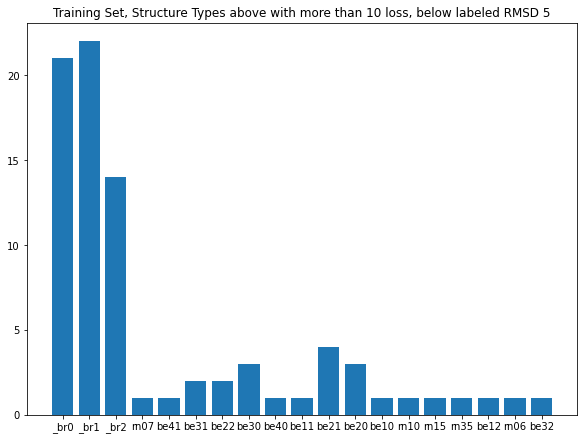

Prediction below 0: Label 17.3050, Pred -9.3480
Validation Set
Minimum Loss: Label = 13.4660, Prediction = 13.6192, Loss = 0.0117
Maximum Loss: Label = 61.9850, Prediction = 19.8779, Loss = 41.6071
Mean Test loss: 	 13.9467
Std. Dev. of Test loss:  8.7338
Min loss: 		 0.0117
First Quantile: 	 7.2455
Median: 		 12.9452
Third Quantile: 	 20.4344
Max Loss: 		 41.6071
LinregressResult(slope=-0.3477645244124187, intercept=31.492196726464147, rvalue=-0.08717984228925761, pvalue=0.08315379886809936, stderr=0.20020014797671956, intercept_stderr=4.815360234375965)


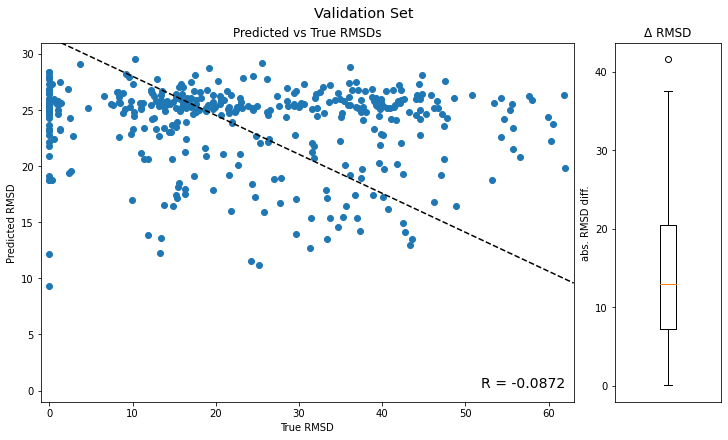

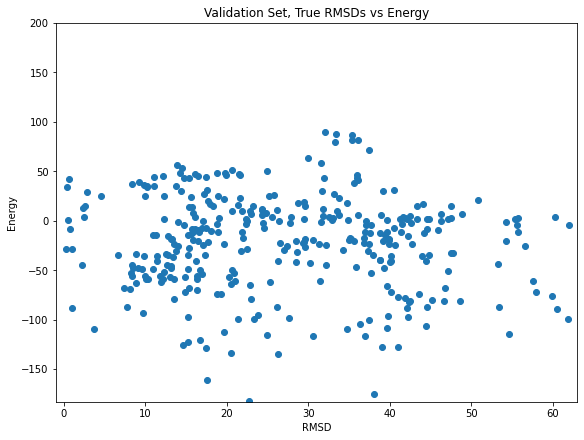

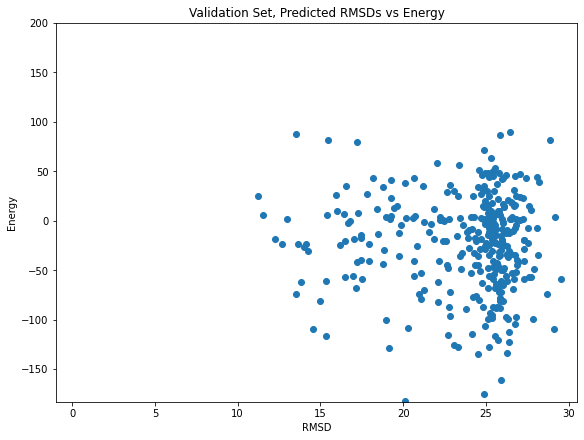

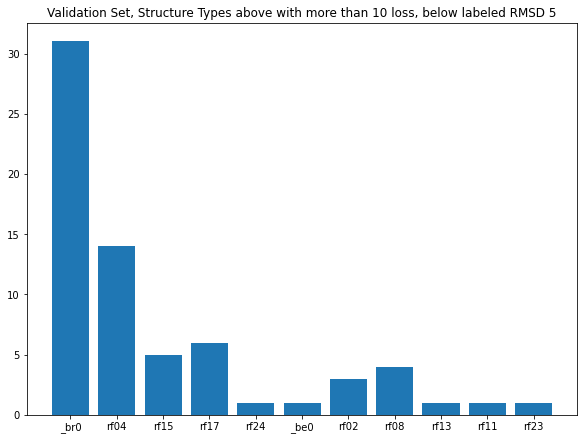

LinregressResult(slope=-0.1596043058412124, intercept=24.61507247703118, rvalue=-0.06773317835618435, pvalue=0.008890812114907288, stderr=0.06092524479328948, intercept_stderr=1.4710571336820628)


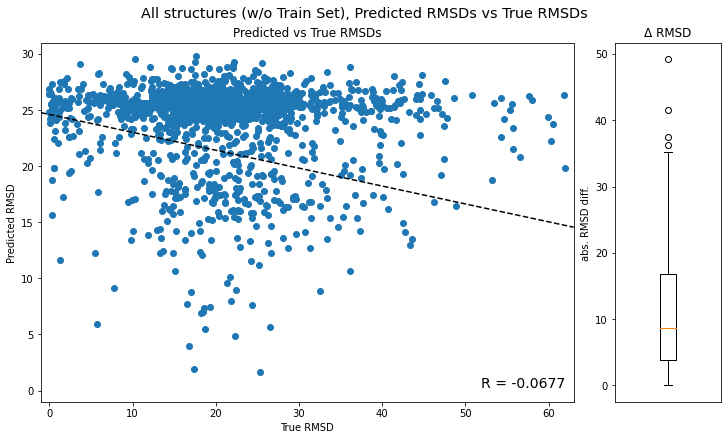

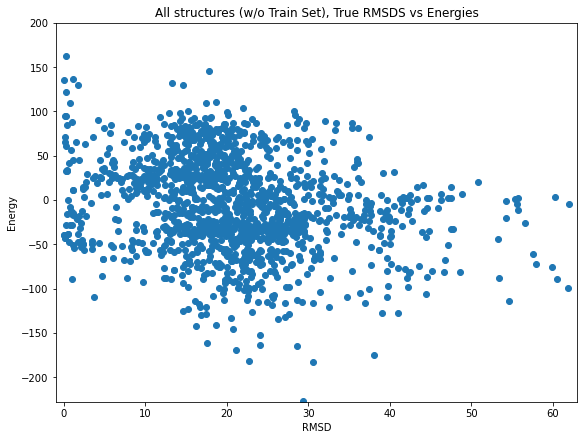

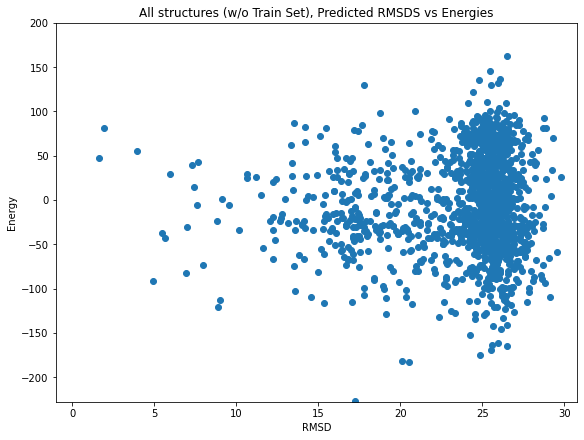

In [5]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = DMoN_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9091579813203675, intercept=1.8185265564939073, rvalue=0.9366382501401529, pvalue=2.694587713881415e-127, stderr=0.020504017003080147, intercept_stderr=0.40753690556040806)


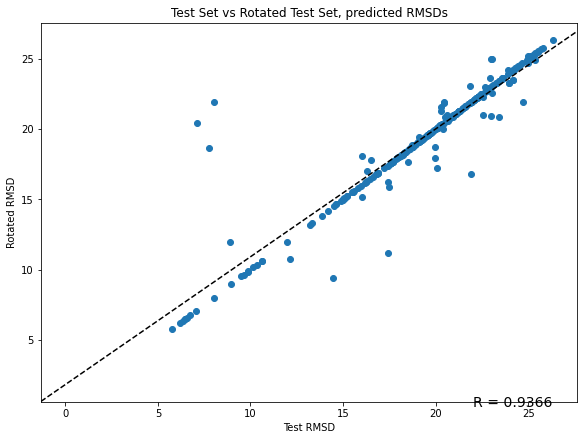

LinregressResult(slope=0.9786476636103387, intercept=0.3422918149869716, rvalue=0.9785232101141297, pvalue=1.2132055836684666e-190, stderr=0.012432089962595764, intercept_stderr=0.168440886827594)


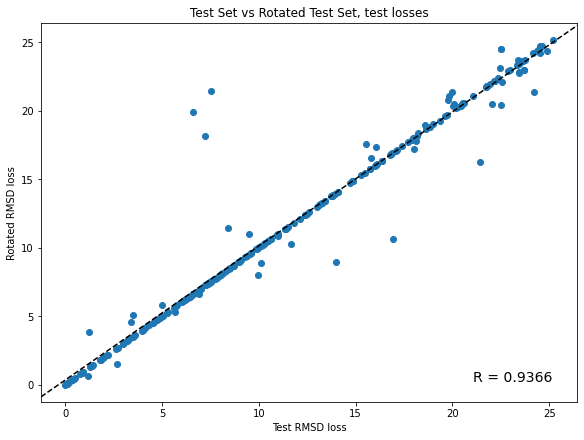

LinregressResult(slope=0.9712626165796127, intercept=0.5077173948013183, rvalue=0.9651781637725774, pvalue=0.0, stderr=0.00800650792132218, intercept_stderr=0.15077171482414378)


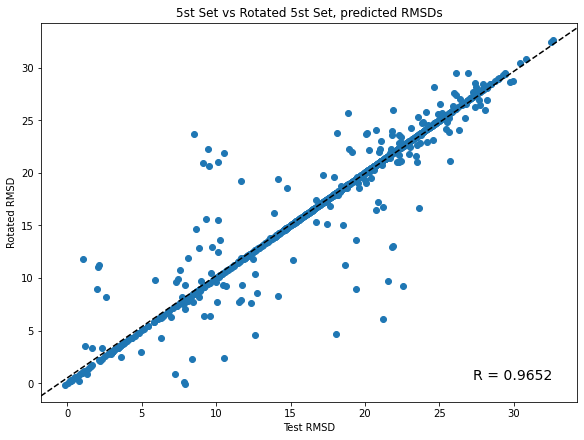

LinregressResult(slope=0.9253551594236874, intercept=0.29146281014302033, rvalue=0.9308669272310164, pvalue=0.0, stderr=0.011046561261775974, intercept_stderr=0.07107113242709055)


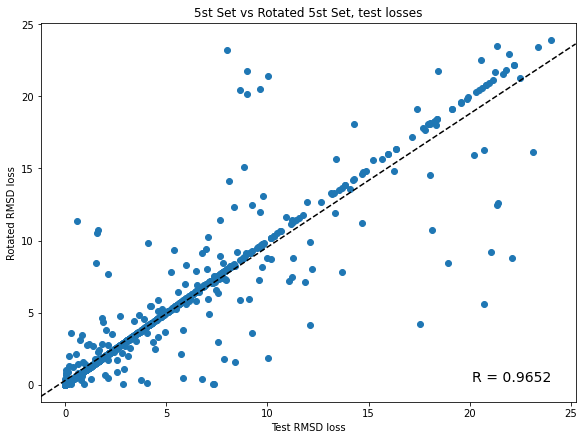

In [20]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")